<a href="https://colab.research.google.com/github/lponcec94/PolyWorks/blob/main/semana_2/Clasificaci%C3%B3n_NaiveBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Introducción 

#### Objetivos: 
  1. Convertir variables númericas a variables categóricas.
  2. Implementar el modelo de clasificación Naive Bayes. 
  3. Clasificar y obtener las probabilidades para cada etiqueta predecida. 
  4. Implentar la curva ROC y observar su comportamiento.
  5. Modificación de la alpha de Laplace dentro de nuestro modelo para alisar el comportamiento. 

#### Importación de datos 

In [1]:
# Montar el drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Moverse a la carpeta donde descargar los datos
import os 
os.environ["KAGGLE_CONFIG_DIR"] = "/content/gdrive/My Drive/Kaggle"
%cd /content/gdrive/MyDrive/Kaggle/semana_2

/content/gdrive/MyDrive/Kaggle/semana_2


In [ ]:
# Descargar los datos desde la API de Kaggle

!kaggle competitions download -c bosch-production-line-performance

In [3]:
# Verificar que se tienen los datos 
%ls

sample_submission.csv.zip  test_numeric.csv.zip       train_numeric.csv.zip
test_categorical.csv.zip   train_categorical.csv.zip
test_date.csv.zip          train_date.csv.zip


#### Importación de módulos 

In [170]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, roc_auc_score, roc_curve

import warnings

warnings.filterwarnings('ignore')

**Lectura de los datos**

In [13]:
# En este caso se limitará la lectura de las filas para poder cargar los datos
# de forma rápida. 

df_num = pd.read_csv('train_numeric.csv.zip', nrows=10_000)
df_cat = pd.read_csv('train_categorical.csv.zip', nrows=10_000)
# df_date = pd.read_csv('train_date.csv.zip', nrows=10_000)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,41,42,43,57,59,60,62,63,65,66,68,69,71,72,74,75,77,78,80,81,83,84,86,87,89,90,92,93,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,188,189,190,191,192,193,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,335,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459

#### Exploración de Datos y modificación para cada tipo de variable

#####*Datos Numéricos*

* Hay que tener en cuenta que los datos de está BD va a tener una gran cantidad de valores nulos. Se requiere hacer una exploración de valores nulos y decidir si es necesario substituirlos o eliminarlos. 

* Recordar que NaiveBayes requiere que convirtamos las variables númericas a variables categóricas. 

* En este caso haremos dos entrenamientos. El primero eliminando en su mayoría los valores nulos, lo cual reducirá la cantidad de características que tenemos. El segundo mantendremos las características completas substiutyendo los nulos. En ambos casos transformaremos las variables númericas a categóricas. 


In [14]:
df_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F52,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F88,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,...,L3_S45_F4126,L3_S45_F4128,L3_S45_F4130,L3_S45_F4132,L3_S47_F4138,L3_S47_F4143,L3_S47_F4148,L3_S47_F4153,L3_S47_F4158,L3_S47_F4163,L3_S47_F4168,L3_S47_F4173,L3_S47_F4178,L3_S47_F4183,L3_S47_F4188,L3_S48_F4193,L3_S48_F4196,L3_S48_F4198,L3_S48_F4200,L3_S48_F4202,L3_S48_F4204,L3_S49_F4206,L3_S49_F4211,L3_S49_F4216,L3_S49_F4221,L3_S49_F4226,L3_S49_F4231,L3_S49_F4236,L3_S50_F4241,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,0.083,-0.273,-0.273,-0.271,0.167,-0.213,-0.023,-0.192,-0.088,0.001,0.0,0.01,-0.223,-0.030,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.001,-0.004,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,7,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,-0.147,0.250,0.250,0.057,-0.079,-0.013,0.011,0.008,-0.060,-0.005,0.0,0.01,-0.223,-0.077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.073,0.138,-0.336,0.506,-0.13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,9,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,-0.046,-0.253,-0.253,0.147,-0.007,-0.013,0.120,0.008,-0.231,0.005,0.0,0.01,0.050,0.056,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.038,-0.001,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,11,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,-0.099,0.042,0.042,-0.012,-0.046,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009,-0.272,-0.051,0.037,0.004,0.0,-0.081,0.311,0.003,0.021,0.015,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [15]:
df_num.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 970 entries, Id to Response
dtypes: float64(968), int64(2)
memory usage: 74.0 MB


In [16]:
df_num.shape # se tienen 970 columnas númericas. 

(10000, 970)

In [17]:
# Se obtiene el promedio de valores nulos. 
null_val = df_num.isnull().mean()
# eliminaremos las columnas donde existe más del 15% de valores nulos
null_columns = null_val[null_val > 0.15] 
print(null_columns)

L0_S0_F0        0.4267
L0_S0_F2        0.4267
L0_S0_F4        0.4267
L0_S0_F6        0.4267
L0_S0_F8        0.4267
                 ...  
L3_S50_F4253    0.9751
L3_S51_F4256    0.9499
L3_S51_F4258    0.9499
L3_S51_F4260    0.9499
L3_S51_F4262    0.9499
Length: 861, dtype: float64


En este primer caso se observa que la mayor cantidad de columnas supera el 15% de valores nulos. Vamos a continuar con esta eliminación, pero hay que tener cuidado en este caso estaríamos eliminando la mayor parte de los datos númericos que se tienen. 

In [18]:
columns_to_drop = null_columns.index

In [19]:
df_num_drop = df_num.drop(columns=columns_to_drop)

In [20]:
# Ahora se tienen 109 columnas 
df_num_drop.shape

(10000, 109)

In [88]:
df_num_drop.head()

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,L3_S29_F3342,L3_S29_F3345,L3_S29_F3348,L3_S29_F3351,L3_S29_F3354,L3_S29_F3357,L3_S29_F3360,L3_S29_F3367,L3_S29_F3370,L3_S29_F3373,L3_S29_F3376,L3_S29_F3379,L3_S29_F3382,L3_S29_F3385,L3_S29_F3388,L3_S29_F3395,L3_S29_F3398,L3_S29_F3401,L3_S29_F3404,L3_S29_F3407,L3_S29_F3412,L3_S29_F3421,L3_S29_F3424,L3_S29_F3427,L3_S29_F3430,L3_S29_F3433,L3_S29_F3436,L3_S29_F3439,L3_S29_F3442,L3_S29_F3449,...,L3_S30_F3729,L3_S30_F3734,L3_S30_F3739,L3_S30_F3744,L3_S30_F3749,L3_S30_F3754,L3_S30_F3759,L3_S30_F3764,L3_S30_F3769,L3_S30_F3774,L3_S30_F3779,L3_S30_F3784,L3_S30_F3789,L3_S30_F3794,L3_S30_F3799,L3_S30_F3804,L3_S30_F3809,L3_S30_F3814,L3_S30_F3819,L3_S30_F3824,L3_S30_F3829,L3_S33_F3855,L3_S33_F3857,L3_S33_F3859,L3_S33_F3861,L3_S33_F3863,L3_S33_F3865,L3_S33_F3867,L3_S33_F3869,L3_S33_F3871,L3_S33_F3873,L3_S34_F3876,L3_S34_F3878,L3_S34_F3880,L3_S34_F3882,L3_S37_F3944,L3_S37_F3946,L3_S37_F3948,L3_S37_F3950,Response
0,4,0.030,-0.047,-0.119,0.040,-0.067,-0.058,0.044,0.044,0.010,0.041,-0.072,-0.024,-0.026,-0.257,0.250,0.218,0.040,0.044,0.090,0.036,-0.117,0.054,-0.119,0.044,-0.024,0.218,-0.072,0.250,-0.702,-0.702,-0.047,-0.058,0.065,-0.069,-0.027,-0.058,0.030,-0.067,0.041,...,0.0,0.0,0.0,-0.177,-0.160,0.091,0.275,0.010,-0.007,0.038,0.013,0.019,0.013,-0.009,0.012,-0.010,-0.060,0.013,-0.027,0.013,0.005,-0.119,-0.102,-0.048,-0.119,-0.119,0.026,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,6,-0.084,-0.030,-0.127,-0.174,0.145,0.152,-0.006,-0.059,-0.064,-0.031,0.023,-0.010,0.113,0.238,-0.050,0.218,-0.174,-0.059,0.085,-0.015,-0.244,-0.050,-0.127,-0.006,-0.010,0.218,0.023,-0.050,0.082,0.082,-0.030,0.152,0.033,0.146,-0.022,0.152,-0.084,0.145,-0.031,...,0.0,0.0,0.0,-0.055,-0.143,-0.079,-0.004,0.012,-0.024,-0.036,0.013,-0.017,0.013,0.011,0.014,0.001,-0.041,0.013,-0.019,0.013,-0.049,-0.029,-0.026,-0.210,-0.029,-0.029,-0.047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,7,0.049,-0.030,-0.099,0.070,0.014,0.004,0.006,0.064,0.040,-0.005,-0.129,-0.138,0.101,0.238,-0.017,-0.115,0.070,0.064,-0.223,0.023,0.223,0.047,-0.099,0.006,-0.138,-0.115,-0.129,-0.017,0.104,0.104,-0.030,0.004,0.071,0.014,-0.022,0.004,0.049,0.014,-0.005,...,0.0,0.0,0.0,-0.155,-0.044,0.059,0.063,0.006,-0.026,0.119,0.013,0.055,0.013,0.081,0.017,0.134,0.115,0.013,0.051,0.013,-0.069,0.199,0.191,0.236,0.199,0.199,0.108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,9,-0.084,-0.139,-0.039,-0.207,0.024,0.025,0.038,-0.033,0.014,0.020,-0.066,-0.038,0.078,-0.099,-0.017,0.218,-0.207,-0.033,0.137,0.030,-0.263,-0.024,-0.039,0.038,-0.038,0.218,-0.066,-0.017,0.063,0.063,-0.139,0.025,0.033,0.024,-0.059,0.025,-0.084,0.024,0.020,...,0.0,0.0,0.0,0.125,0.147,-0.173,-0.156,0.013,0.022,0.028,0.013,0.013,0.013,0.005,0.014,0.027,0.057,0.013,0.025,0.013,-0.014,0.017,0.031,0.165,0.017,0.017,0.035,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,11,-0.147,-0.082,-0.091,-0.137,-0.049,-0.063,-0.163,-0.111,0.053,0.033,0.127,0.089,-0.167,-0.257,-0.050,0.218,-0.137,-0.111,-0.347,-0.149,0.099,-0.128,-0.091,-0.163,0.089,0.218,0.127,-0.050,0.101,0.101,-0.082,-0.063,0.015,-0.050,-0.039,-0.063,-0.147,-0.049,0.033,...,0.0,0.0,0.0,0.137,0.070,0.004,-0.129,0.010,0.022,0.056,0.013,0.025,0.013,-0.015,0.012,0.001,0.004,0.013,0.001,0.013,-0.056,-0.074,-0.049,0.147,-0.074,-0.074,-0.006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


En este caso tenemos los datos para el primer entrenamiento. Vamos a obtener los datos para el segundo entrenamiento.

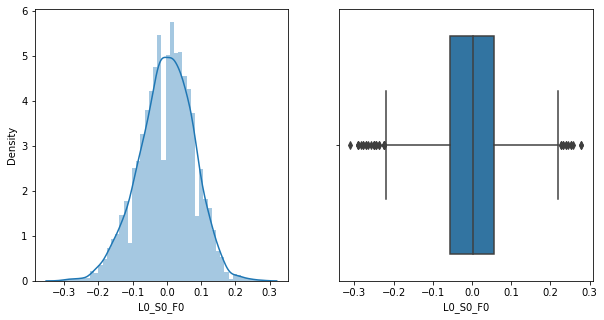

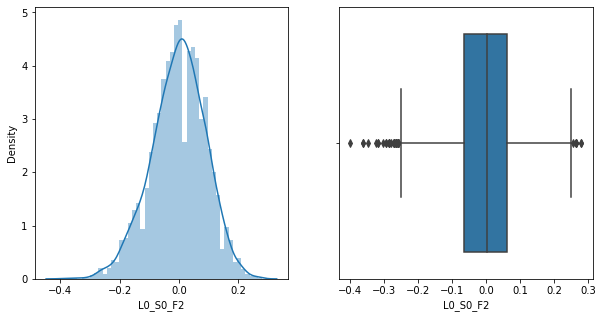

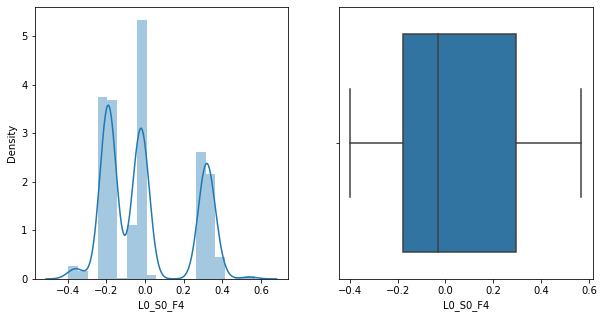

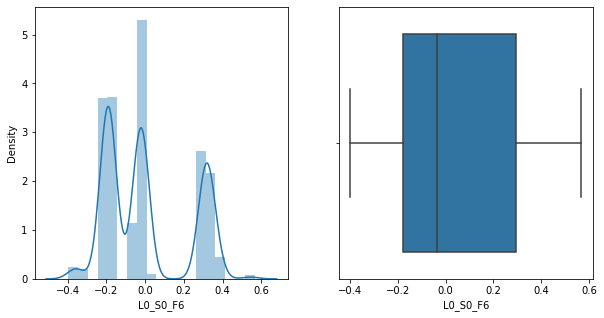

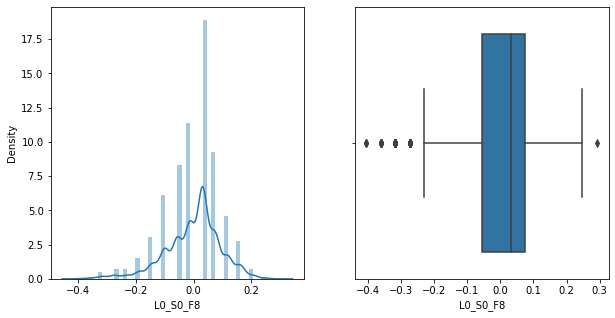

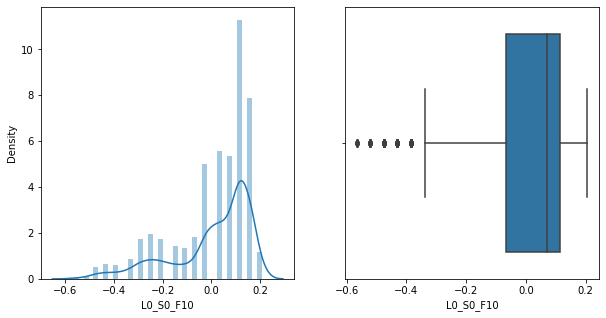

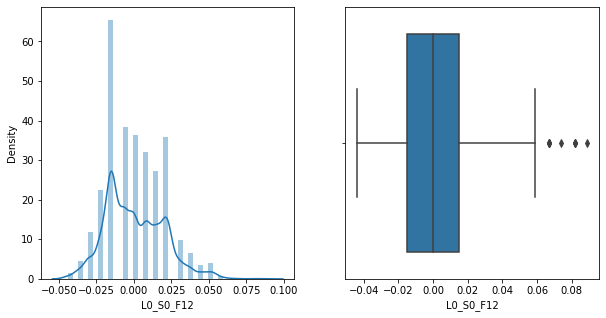

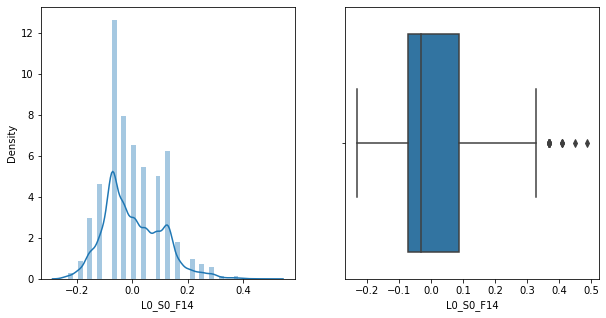

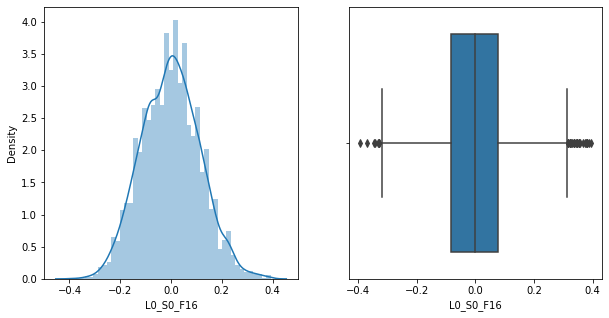

In [27]:
# Vamos a reemplazar los valores nulos, pero antes observemos su distribución. 

for col in df_num.columns[1:10]:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  sns.distplot(df_num[col], kde=True, ax=axes[0])
  sns.boxplot(df_num[col], orient='h' ,ax=axes[1]);

In [33]:
for col in df_num.columns:
  df_num_fill[col] = df_num[col].fillna(df_num[col].mean())

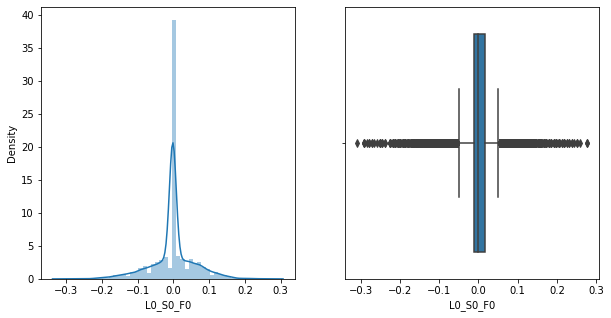

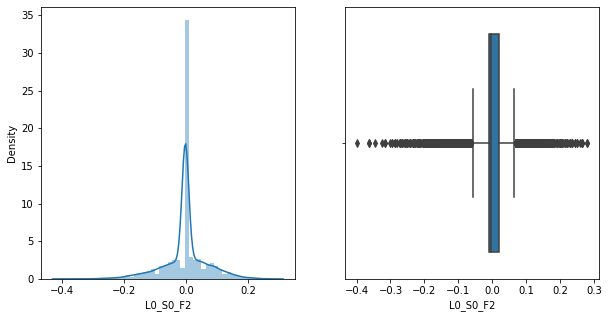

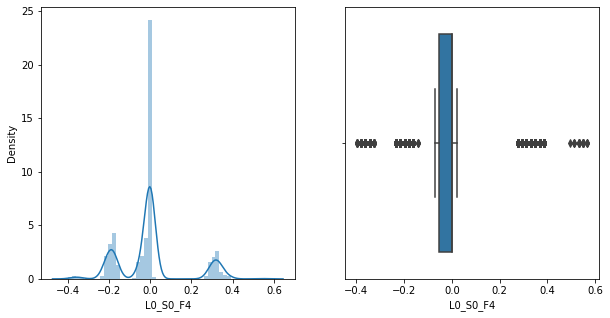

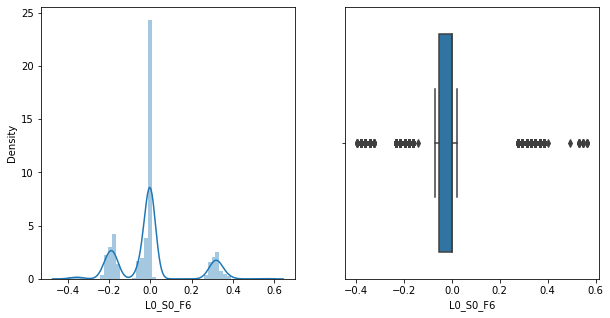

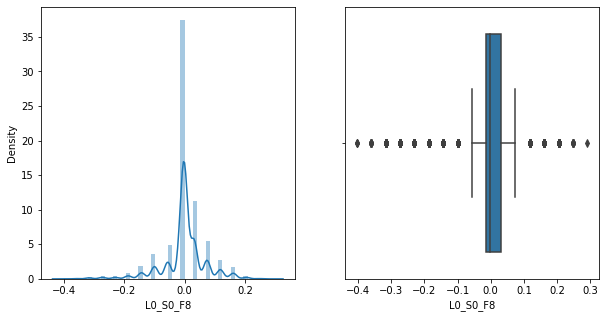

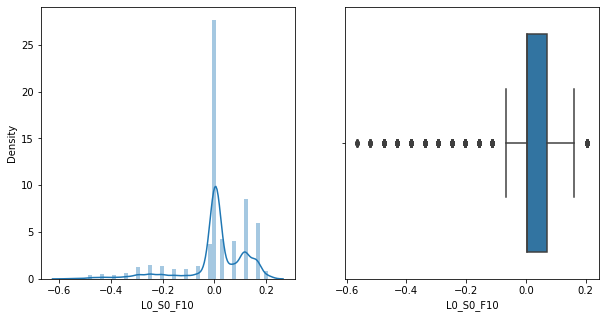

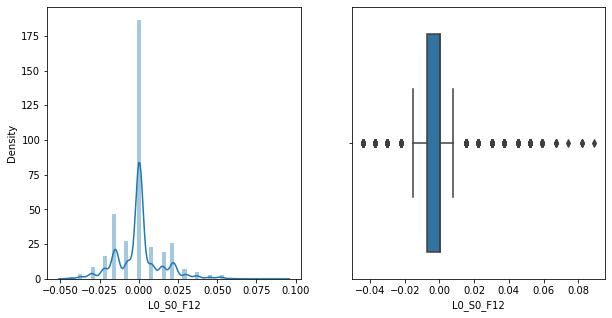

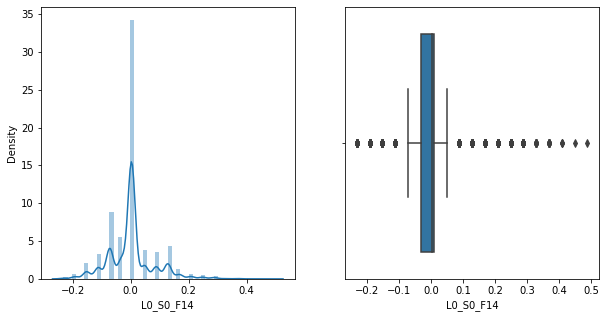

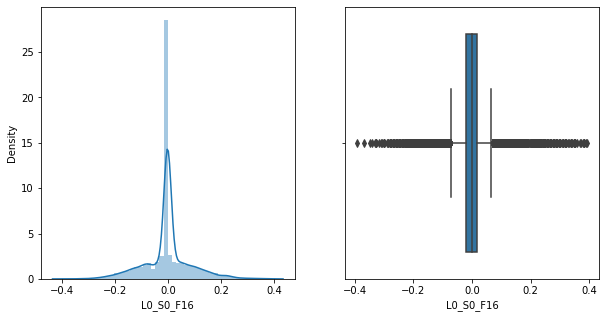

In [34]:
for col in df_num_fill.columns[1:10]:
  fig, axes = plt.subplots(1, 2, figsize=(10, 5))
  sns.distplot(df_num_fill[col], kde=True, ax=axes[0])
  sns.boxplot(df_num_fill[col], orient='h' ,ax=axes[1]);

In [36]:
# Verificamos que no tengamos nulos
df_num_fill.isnull().sum().sum()

0

In [56]:
df_num_bins = pd.DataFrame()
for col in df_num_fill.columns[1:-1]:
  df_num_bins[col] = pd.qcut(df_num_fill[col], 5, duplicates='drop') 

In [57]:
df_num_bins.head(10)

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F52,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F88,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,L0_S7_F136,...,L3_S44_F4121,L3_S45_F4124,L3_S45_F4126,L3_S45_F4128,L3_S45_F4130,L3_S45_F4132,L3_S47_F4138,L3_S47_F4143,L3_S47_F4148,L3_S47_F4153,L3_S47_F4158,L3_S47_F4163,L3_S47_F4168,L3_S47_F4173,L3_S47_F4178,L3_S47_F4183,L3_S47_F4188,L3_S48_F4193,L3_S48_F4196,L3_S48_F4198,L3_S48_F4200,L3_S48_F4202,L3_S48_F4204,L3_S49_F4206,L3_S49_F4211,L3_S49_F4216,L3_S49_F4221,L3_S49_F4231,L3_S49_F4236,L3_S50_F4241,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,"(-0.0019, 0.03]","(-0.4, -0.034]","(-0.398, -0.179]","(-0.398, -0.179]","(0.031, 0.292]","(0.00413, 0.116]","(-0.045, -0.015]","(-0.072, 0.00232]","(-0.000786, 0.041]","(0.045, 0.409]","(-0.342, -0.104]","(-0.342, -0.104]","(-0.288, -0.043]","(0.03, 0.494]","(-0.214, -0.013]","(-0.309, 0.00991]","(-0.193, -0.00165]","(-0.374, 0.00136]","(2.56e-05, 0.011]",NaN,"(0.00101, 0.01]","(-0.366, -0.00906]","(-0.177, 0.00281]","(-0.192, -0.000799]","(-0.275, 0.00766]","(-0.152, 0.000108]","(-0.351, 0.00467]","(-0.039, 8.97e-05]",NaN,"(-0.182, 0.000544]","(-0.291, -0.00101]","(-0.091, 0.000147]","(-0.859, 0.000726]","(-0.048, 0.000444]","(-0.477, -0.00145]","(-0.208, 0.00175]","(-0.337, -0.00499]","(-0.324, 0.00992]","(-0.143, 0.00161]","(-0.165, 0.00534]",...,"(-0.076, -0.0227]","(-0.467, -0.00141]","(-0.001, 1.99e-06]","(-0.001, 0.00169]","(-0.001, 1.99e-05]","(-0.001, 7.97e-05]","(-0.247, 0.00103]","(-0.012, -5.99e-06]","(-0.27, 0.000403]","(-0.343, -0.00162]","(-0.472, 0.00199]","(-0.288, 0.0032]","(-0.27, 0.000403]",NaN,"(-0.001, 0.00016]","(-0.001, 4.39e-05]","(-0.001, 6.79e-05]","(-0.521, 0.0114]","(-0.478, 0.0178]","(-0.574, -0.000345]",NaN,"(-0.001, 0.000191]","(-0.001, 7.57e-05]","(-0.003, -0.00103]","(-0.087, 0.000142]","(-0.002, -3.95e-06]","(-0.001, 0.000111]","(-0.001, 4.74e-05]","(-0.25, 1.19e-05]","(-0.532, -0.0161]","(-0.258, -0.0076]","(-0.002, -8.03e-06]","(-0.001, 8.03e-06]","(-0.001, 4.82e-05]","(-0.001, 0.000189]","(-0.251, 0.001]","(-0.002, -7.98e-06]","(-0.001, 5.99e-06]","(-0.001, 6.19e-05]","(-0.001, 9.18e-05]"
1,"(-0.029, -0.0019]","(-0.034, -0.0026]","(-0.179, 0.00101]","(-0.179, 0.000744]","(-0.013, -0.00116]","(-0.021, 0.00413]","(-0.015, 0.000347]","(-0.072, 0.00232]","(-0.046, -0.000786]","(-0.046, 0.000256]","(-0.104, 0.00486]","(-0.104, 0.00487]","(-0.043, 0.00144]","(-0.049, 0.000558]","(-0.013, -0.0017]","(-0.309, 0.00991]","(-0.193, -0.00165]","(-0.374, 0.00136]","(-0.038, 2.56e-05]",NaN,"(-0.191, 0.00101]","(-0.366, -0.00906]","(-0.177, 0.00281]","(-0.192, -0.000799]","(-0.275, 0.00766]","(-0.152, 0.000108]","(-0.351, 0.00467]","(-0.039, 8.97e-05]",NaN,"(-0.182, 0.000544]","(-0.291, -0.00101]","(-0.091, 0.000147]","(-0.859, 0.000726]","(-0.048, 0.000444]","(-0.477, -0.00145]","(-0.208, 0.00175]","(-0.337, -0.00499]","(-0.324, 0.00992]","(-0.143, 0.00161]","(-0.165, 0.00534]",...,"(-0.076, -0.0227]","(-0.467, -0.00141]","(-0.001, 1.99e-06]","(-0.001, 0.00169]","(-0.001, 1.99e-05]","(-0.001, 7.97e-05]","(-0.247, 0.00103]","(-0.012, -5.99e-06]","(-0.27, 0.000403]","(-0.343, -0.00162]","(-0.472, 0.00199]","(-0.288, 0.0032]","(-0.27, 0.000403]",NaN,"(-0.001, 0.00016]","(-0.001, 4.39e-05]","(-0.001, 6.79e-05]","(-0.521, 0.0114]","(-0.478, 0.0178]","(-0.574, -0.000345]",NaN,"(-0.001, 0.000191]","(-0.001, 7.57e-05]","(-0.003, -0.00103]","(-0.087, 0.000142]","(-0.002, -3.95e-06]","(-0.001, 0.000111]","(-0.001, 4.74e-05]","(-0.25, 1.19e-05]","(-0.532, -0.0161]","(-0.258, -0.0076]","(-0.002, -8.03e-06]","(-0.001, 8.03e-06]","(-0.001, 4.82e-05]","(-0.001, 0.000189]","(-0.251, 0.001]","(-0.002, -7.9

In [58]:
df_num_bins.shape

(10000, 967)

In [59]:
df_num_bins.dropna(axis=1, how='all', inplace=True)

In [60]:
for col in df_num_bins.columns:
  enc = OrdinalEncoder()
  df_num_bins[col] = enc.fit_transform(df_num_bins[[col]]).flatten()

In [61]:
df_num_bins.head(10)

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,L0_S7_F136,L0_S7_F138,L0_S7_F142,...,L3_S44_F4115,L3_S44_F4118,L3_S44_F4121,L3_S45_F4124,L3_S45_F4126,L3_S45_F4128,L3_S45_F4130,L3_S45_F4132,L3_S47_F4138,L3_S47_F4143,L3_S47_F4148,L3_S47_F4153,L3_S47_F4158,L3_S47_F4163,L3_S47_F4168,L3_S47_F4178,L3_S47_F4183,L3_S47_F4188,L3_S48_F4193,L3_S48_F4196,L3_S48_F4198,L3_S48_F4202,L3_S48_F4204,L3_S49_F4206,L3_S49_F4211,L3_S49_F4216,L3_S49_F4221,L3_S49_F4231,L3_S49_F4236,L3_S50_F4241,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3.0,3.0,2.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,2.0,2.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,2.0,2.0,3.0,2.0,3.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2.0,2.0,2.0,2.0,2.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,1.0,0.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [62]:
df_num_bins.tail(10)

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,L0_S7_F136,L0_S7_F138,L0_S7_F142,...,L3_S44_F4115,L3_S44_F4118,L3_S44_F4121,L3_S45_F4124,L3_S45_F4126,L3_S45_F4128,L3_S45_F4130,L3_S45_F4132,L3_S47_F4138,L3_S47_F4143,L3_S47_F4148,L3_S47_F4153,L3_S47_F4158,L3_S47_F4163,L3_S47_F4168,L3_S47_F4178,L3_S47_F4183,L3_S47_F4188,L3_S48_F4193,L3_S48_F4196,L3_S48_F4198,L3_S48_F4202,L3_S48_F4204,L3_S49_F4206,L3_S49_F4211,L3_S49_F4216,L3_S49_F4221,L3_S49_F4231,L3_S49_F4236,L3_S50_F4241,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
9990,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9991,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
9992,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9993,1.0,1.0,1.0,1.0,0.0,2.0,1.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9994,1.0,0.0,0.0,1.0,2.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,2.0,2.0,2.0,0.0,0.0,3.0,3.0,3.0,0.0,3.0,3.0,3.0,0.0,0.0,1.0,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9999,1.0,1.0,1.0,1.0,3.0,3.0,1.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0

In [63]:
df_id_resp = df_num[['Id', 'Response']]
df_id_resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   Id        10000 non-null  int64
 1   Response  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


In [65]:
df_num_2 = pd.concat([df_id_resp, df_num_bins], axis=1)
df_num_2.head()

,Id,Response,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,L0_S7_F136,...,L3_S44_F4115,L3_S44_F4118,L3_S44_F4121,L3_S45_F4124,L3_S45_F4126,L3_S45_F4128,L3_S45_F4130,L3_S45_F4132,L3_S47_F4138,L3_S47_F4143,L3_S47_F4148,L3_S47_F4153,L3_S47_F4158,L3_S47_F4163,L3_S47_F4168,L3_S47_F4178,L3_S47_F4183,L3_S47_F4188,L3_S48_F4193,L3_S48_F4196,L3_S48_F4198,L3_S48_F4202,L3_S48_F4204,L3_S49_F4206,L3_S49_F4211,L3_S49_F4216,L3_S49_F4221,L3_S49_F4231,L3_S49_F4236,L3_S50_F4241,L3_S50_F4243,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262
0,4,0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,6,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7,0,3.0,3.0,2.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9,0,0.0,0.0,2.0,2.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11,0,0.0,0.0,2.0,2.0,3.0,2.0,3.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#####*Datos Categóricos*

En los datos categóricos se observa también que existe una gran cantidad de valores nulos. 

In [66]:
df_cat.head()

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,L0_S2_F43,L0_S2_F45,L0_S2_F47,L0_S2_F49,L0_S2_F51,L0_S2_F53,L0_S2_F55,L0_S2_F57,L0_S2_F59,L0_S2_F61,L0_S2_F63,L0_S2_F65,L0_S2_F67,L0_S3_F69,L0_S3_F71,L0_S3_F73,L0_S3_F75,L0_S3_F77,L0_S3_F79,L0_S3_F81,L0_S3_F83,L0_S3_F85,L0_S3_F87,L0_S3_F89,L0_S3_F91,L0_S3_F93,L0_S3_F95,L0_S3_F97,L0_S3_F99,L0_S3_F101,...,L3_S47_F4162,L3_S47_F4164,L3_S47_F4166,L3_S47_F4167,L3_S47_F4169,L3_S47_F4171,L3_S47_F4172,L3_S47_F4174,L3_S47_F4176,L3_S47_F4177,L3_S47_F4179,L3_S47_F4181,L3_S47_F4182,L3_S47_F4184,L3_S47_F4186,L3_S47_F4187,L3_S47_F4189,L3_S47_F4191,L3_S47_F4192,L3_S49_F4207,L3_S49_F4209,L3_S49_F4210,L3_S49_F4212,L3_S49_F4214,L3_S49_F4215,L3_S49_F4217,L3_S49_F4219,L3_S49_F4220,L3_S49_F4222,L3_S49_F4224,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
df_cat.shape

(10000, 2141)

In [70]:
null_val = df_cat.isnull().mean()
null_columns_50 = null_val[null_val.values > 0.50]
null_columns_50

L0_S1_F25       0.9999
L0_S1_F27       0.9999
L0_S1_F29       0.9999
L0_S1_F31       0.9999
L0_S2_F33       0.9999
                 ...  
L3_S49_F4234    1.0000
L3_S49_F4235    1.0000
L3_S49_F4237    1.0000
L3_S49_F4239    1.0000
L3_S49_F4240    1.0000
Length: 2077, dtype: float64

In [71]:
columns_to_drop = null_columns_50.index

In [80]:
df_cat_drop = df_cat.drop(columns=columns_to_drop)

In [81]:
df_cat_drop.shape

(10000, 64)

In [82]:
df_cat_drop = df_cat_drop.fillna(value='0')

In [83]:
df_cat_drop.head()

,Id,L3_S29_F3317,L3_S29_F3320,L3_S29_F3323,L3_S29_F3326,L3_S29_F3329,L3_S29_F3332,L3_S29_F3335,L3_S29_F3338,L3_S29_F3341,L3_S29_F3344,L3_S29_F3347,L3_S29_F3350,L3_S29_F3353,L3_S29_F3356,L3_S29_F3359,L3_S29_F3362,L3_S29_F3364,L3_S29_F3366,L3_S29_F3369,L3_S29_F3372,L3_S29_F3375,L3_S29_F3378,L3_S29_F3381,L3_S29_F3384,L3_S29_F3387,L3_S29_F3390,L3_S29_F3392,L3_S29_F3394,L3_S29_F3397,L3_S29_F3400,L3_S29_F3403,L3_S29_F3406,L3_S29_F3409,L3_S29_F3411,L3_S29_F3414,L3_S29_F3416,L3_S29_F3418,L3_S29_F3420,L3_S29_F3423,L3_S29_F3426,L3_S29_F3429,L3_S29_F3432,L3_S29_F3435,L3_S29_F3438,L3_S29_F3441,L3_S29_F3444,L3_S29_F3446,L3_S29_F3448,L3_S29_F3451,L3_S29_F3454,L3_S29_F3457,L3_S29_F3460,L3_S29_F3463,L3_S29_F3466,L3_S29_F3469,L3_S29_F3472,L3_S29_F3475,L3_S29_F3478,L3_S29_F3481,L3_S29_F3484,L3_S29_F3487,L3_S29_F3490,L3_S29_F3493
0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,7,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1
3,9,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1
4,11,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1


In [84]:
df_cat_enc = pd.DataFrame()

for col in df_cat_drop.columns:
  enc = OrdinalEncoder()
  df_cat_enc[col] = enc.fit_transform(df_cat_drop[[col]]).flatten()


In [85]:
df_cat_enc.head()

,Id,L3_S29_F3317,L3_S29_F3320,L3_S29_F3323,L3_S29_F3326,L3_S29_F3329,L3_S29_F3332,L3_S29_F3335,L3_S29_F3338,L3_S29_F3341,L3_S29_F3344,L3_S29_F3347,L3_S29_F3350,L3_S29_F3353,L3_S29_F3356,L3_S29_F3359,L3_S29_F3362,L3_S29_F3364,L3_S29_F3366,L3_S29_F3369,L3_S29_F3372,L3_S29_F3375,L3_S29_F3378,L3_S29_F3381,L3_S29_F3384,L3_S29_F3387,L3_S29_F3390,L3_S29_F3392,L3_S29_F3394,L3_S29_F3397,L3_S29_F3400,L3_S29_F3403,L3_S29_F3406,L3_S29_F3409,L3_S29_F3411,L3_S29_F3414,L3_S29_F3416,L3_S29_F3418,L3_S29_F3420,L3_S29_F3423,L3_S29_F3426,L3_S29_F3429,L3_S29_F3432,L3_S29_F3435,L3_S29_F3438,L3_S29_F3441,L3_S29_F3444,L3_S29_F3446,L3_S29_F3448,L3_S29_F3451,L3_S29_F3454,L3_S29_F3457,L3_S29_F3460,L3_S29_F3463,L3_S29_F3466,L3_S29_F3469,L3_S29_F3472,L3_S29_F3475,L3_S29_F3478,L3_S29_F3481,L3_S29_F3484,L3_S29_F3487,L3_S29_F3490,L3_S29_F3493
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,4.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [86]:
df_cat_enc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 64 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Id            10000 non-null  float64
 1   L3_S29_F3317  10000 non-null  float64
 2   L3_S29_F3320  10000 non-null  float64
 3   L3_S29_F3323  10000 non-null  float64
 4   L3_S29_F3326  10000 non-null  float64
 5   L3_S29_F3329  10000 non-null  float64
 6   L3_S29_F3332  10000 non-null  float64
 7   L3_S29_F3335  10000 non-null  float64
 8   L3_S29_F3338  10000 non-null  float64
 9   L3_S29_F3341  10000 non-null  float64
 10  L3_S29_F3344  10000 non-null  float64
 11  L3_S29_F3347  10000 non-null  float64
 12  L3_S29_F3350  10000 non-null  float64
 13  L3_S29_F3353  10000 non-null  float64
 14  L3_S29_F3356  10000 non-null  float64
 15  L3_S29_F3359  10000 non-null  float64
 16  L3_S29_F3362  10000 non-null  float64
 17  L3_S29_F3364  10000 non-null  float64
 18  L3_S29_F3366  10000 non-nul

##### Datos para los modelos 

In [112]:
data_1 = df_num_drop.join(df_cat_enc.set_index('Id'), on='Id', how='inner')
data_1.head()

,Id,L3_S29_F3315,L3_S29_F3318,L3_S29_F3321,L3_S29_F3324,L3_S29_F3327,L3_S29_F3330,L3_S29_F3333,L3_S29_F3336,L3_S29_F3339,L3_S29_F3342,L3_S29_F3345,L3_S29_F3348,L3_S29_F3351,L3_S29_F3354,L3_S29_F3357,L3_S29_F3360,L3_S29_F3367,L3_S29_F3370,L3_S29_F3373,L3_S29_F3376,L3_S29_F3379,L3_S29_F3382,L3_S29_F3385,L3_S29_F3388,L3_S29_F3395,L3_S29_F3398,L3_S29_F3401,L3_S29_F3404,L3_S29_F3407,L3_S29_F3412,L3_S29_F3421,L3_S29_F3424,L3_S29_F3427,L3_S29_F3430,L3_S29_F3433,L3_S29_F3436,L3_S29_F3439,L3_S29_F3442,L3_S29_F3449,...,L3_S29_F3384,L3_S29_F3387,L3_S29_F3390,L3_S29_F3392,L3_S29_F3394,L3_S29_F3397,L3_S29_F3400,L3_S29_F3403,L3_S29_F3406,L3_S29_F3409,L3_S29_F3411,L3_S29_F3414,L3_S29_F3416,L3_S29_F3418,L3_S29_F3420,L3_S29_F3423,L3_S29_F3426,L3_S29_F3429,L3_S29_F3432,L3_S29_F3435,L3_S29_F3438,L3_S29_F3441,L3_S29_F3444,L3_S29_F3446,L3_S29_F3448,L3_S29_F3451,L3_S29_F3454,L3_S29_F3457,L3_S29_F3460,L3_S29_F3463,L3_S29_F3466,L3_S29_F3469,L3_S29_F3472,L3_S29_F3475,L3_S29_F3478,L3_S29_F3481,L3_S29_F3484,L3_S29_F3487,L3_S29_F3490,L3_S29_F3493
0,4,0.030,-0.047,-0.119,0.040,-0.067,-0.058,0.044,0.044,0.010,0.041,-0.072,-0.024,-0.026,-0.257,0.250,0.218,0.040,0.044,0.090,0.036,-0.117,0.054,-0.119,0.044,-0.024,0.218,-0.072,0.250,-0.702,-0.702,-0.047,-0.058,0.065,-0.069,-0.027,-0.058,0.030,-0.067,0.041,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,6,-0.084,-0.030,-0.127,-0.174,0.145,0.152,-0.006,-0.059,-0.064,-0.031,0.023,-0.010,0.113,0.238,-0.050,0.218,-0.174,-0.059,0.085,-0.015,-0.244,-0.050,-0.127,-0.006,-0.010,0.218,0.023,-0.050,0.082,0.082,-0.030,0.152,0.033,0.146,-0.022,0.152,-0.084,0.145,-0.031,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,7,0.049,-0.030,-0.099,0.070,0.014,0.004,0.006,0.064,0.040,-0.005,-0.129,-0.138,0.101,0.238,-0.017,-0.115,0.070,0.064,-0.223,0.023,0.223,0.047,-0.099,0.006,-0.138,-0.115,-0.129,-0.017,0.104,0.104,-0.030,0.004,0.071,0.014,-0.022,0.004,0.049,0.014,-0.005,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,9,-0.084,-0.139,-0.039,-0.207,0.024,0.025,0.038,-0.033,0.014,0.020,-0.066,-0.038,0.078,-0.099,-0.017,0.218,-0.207,-0.033,0.137,0.030,-0.263,-0.024,-0.039,0.038,-0.038,0.218,-0.066,-0.017,0.063,0.063,-0.139,0.025,0.033,0.024,-0.059,0.025,-0.084,0.024,0.020,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,11,-0.147,-0.082,-0.091,-0.137,-0.049,-0.063,-0.163,-0.111,0.053,0.033,0.127,0.089,-0.167,-0.257,-0.050,0.218,-0.137,-0.111,-0.347,-0.149,0.099,-0.128,-0.091,-0.163,0.089,0.218,0.127,-0.050,0.101,0.101,-0.082,-0.063,0.015,-0.050,-0.039,-0.063,-0.147,-0.049,0.033,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [113]:
data_1.shape

(5012, 172)

In [114]:
data_1.isnull().sum()

Id                0
L3_S29_F3315    261
L3_S29_F3318    261
L3_S29_F3321    261
L3_S29_F3324    261
               ... 
L3_S29_F3481      0
L3_S29_F3484      0
L3_S29_F3487      0
L3_S29_F3490      0
L3_S29_F3493      0
Length: 172, dtype: int64

In [115]:
data_1.dropna(axis=0, inplace=True)

In [116]:
data_1.shape

(4478, 172)

In [117]:
data_1.isnull().sum().sum()

0

In [ ]:
#set(df_num_drop['Id']).difference(set(df_cat_enc['Id']))

In [118]:
data_2 = df_num_2.join(df_cat_enc.set_index('Id'), on='Id', how='inner')
data_2.head()

,Id,Response,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,L0_S7_F136,...,L3_S29_F3384,L3_S29_F3387,L3_S29_F3390,L3_S29_F3392,L3_S29_F3394,L3_S29_F3397,L3_S29_F3400,L3_S29_F3403,L3_S29_F3406,L3_S29_F3409,L3_S29_F3411,L3_S29_F3414,L3_S29_F3416,L3_S29_F3418,L3_S29_F3420,L3_S29_F3423,L3_S29_F3426,L3_S29_F3429,L3_S29_F3432,L3_S29_F3435,L3_S29_F3438,L3_S29_F3441,L3_S29_F3444,L3_S29_F3446,L3_S29_F3448,L3_S29_F3451,L3_S29_F3454,L3_S29_F3457,L3_S29_F3460,L3_S29_F3463,L3_S29_F3466,L3_S29_F3469,L3_S29_F3472,L3_S29_F3475,L3_S29_F3478,L3_S29_F3481,L3_S29_F3484,L3_S29_F3487,L3_S29_F3490,L3_S29_F3493
0,4,0,2.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,2.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,6,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,7,0,3.0,3.0,2.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,9,0,0.0,0.0,2.0,2.0,3.0,3.0,3.0,3.0,1.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,11,0,0.0,0.0,2.0,2.0,3.0,2.0,3.0,3.0,0.0,0.0,2.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [119]:
data_2.tail()

,Id,Response,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,L0_S0_F20,L0_S0_F22,L0_S1_F24,L0_S1_F28,L0_S2_F32,L0_S2_F36,L0_S2_F40,L0_S2_F44,L0_S2_F48,L0_S2_F56,L0_S2_F60,L0_S2_F64,L0_S3_F68,L0_S3_F72,L0_S3_F76,L0_S3_F80,L0_S3_F84,L0_S3_F92,L0_S3_F96,L0_S3_F100,L0_S4_F104,L0_S4_F109,L0_S5_F114,L0_S5_F116,L0_S6_F118,L0_S6_F122,L0_S6_F132,L0_S7_F136,...,L3_S29_F3384,L3_S29_F3387,L3_S29_F3390,L3_S29_F3392,L3_S29_F3394,L3_S29_F3397,L3_S29_F3400,L3_S29_F3403,L3_S29_F3406,L3_S29_F3409,L3_S29_F3411,L3_S29_F3414,L3_S29_F3416,L3_S29_F3418,L3_S29_F3420,L3_S29_F3423,L3_S29_F3426,L3_S29_F3429,L3_S29_F3432,L3_S29_F3435,L3_S29_F3438,L3_S29_F3441,L3_S29_F3444,L3_S29_F3446,L3_S29_F3448,L3_S29_F3451,L3_S29_F3454,L3_S29_F3457,L3_S29_F3460,L3_S29_F3463,L3_S29_F3466,L3_S29_F3469,L3_S29_F3472,L3_S29_F3475,L3_S29_F3478,L3_S29_F3481,L3_S29_F3484,L3_S29_F3487,L3_S29_F3490,L3_S29_F3493
5007,9992,0,3.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,3.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5008,9993,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5009,9994,0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5010,9996,0,3.0,3.0,1.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,3.0,3.0,3.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5011,9999,0,3.0,2.0,1.0,2.0,3.0,2.0,1.0,1.0,2.0,0.0,3.0,3.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [120]:
data_2.shape

(5012, 1006)

In [122]:
data_2.isnull().sum().sum()

0

##### Naive Bayes 

In [125]:
def split_data(data: pd.DataFrame, y: str):
  """
  This functions divides the data into independent 
  variables and the dependent variable. 

  Returns
    tuple with split data into train and test. 
  """
  X = data.drop(columns=y)
  y = data[y]

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42)
  
  print('X_train shape: ', X_train.shape)
  print('X_test shape: ', X_test.shape)
  print('y_train shape: ', y_train.shape)
  print('y_test shape: ', y_test.shape)

  return X_train, X_test, y_train, y_test

In [149]:
def training_model_evaluation(X_train, X_test, y_train, y_test, classifier):
  """
  Function that trains a model and gives you evaluation metrics.
  """
  
  model = classifier
  clf = model.fit(X_train, y_train)

  pred_labels_train = model.predict(X_train)
  pred_labels_test = model.predict(X_test)


  print('Classes: ', clf.classes_ ) # labels known to the classifier

  # model_name = str(classifier).split('(')[0]
  # if model_name == 'GaussianNB':
  #   print('Class Priors', clf.class_prior_) # prior probability of each class
  # else:
  #   print('Class Log Prior:', clf.class_log_prior_) # log prior probability of each class

  print("----"*10)
  score_train = model.score(X_train, y_train)
  score_test = model.score(X_test, y_test)
  print('Accuracy Score Train: ', score_train)
  print('Accuracy Score Test: ', score_test)
  print("----"*10)

  print()

  print("----"*10)
  print('Train Report')
  print(classification_report(y_train, pred_labels_train))
  print('Test Report')
  print(classification_report(y_test, pred_labels_test))
  
  print()
  print('-----'*10)
  y_pred_prob_train = clf.predict_proba(X_train)[::, 1]
  fpr, tpr, _ = roc_curve(y_train, y_pred_prob_train)
  auc = roc_auc_score(y_train, y_pred_prob_train)

  plt.plot(fpr, tpr)
  plt.show()

  print("AUC Score Train: ", auc)

  print()
  print('-----'*10)
  y_pred_prob_test = clf.predict_proba(X_test)[::, 1]
  fpr, tpr, _ = roc_curve(y_test, y_pred_prob_test)
  auc = roc_auc_score(y_test, y_pred_prob_test)

  plt.plot(fpr, tpr)
  plt.show()

  print("AUC Score Test: ", auc)

  return clf, pred_labels_train, pred_labels_test, y_pred_prob_train, y_pred_prob_test

In [150]:
X_train, X_test, y_train, y_test = split_data(data_1, 'Response')

X_train shape:  (3582, 171)
X_test shape:  (896, 171)
y_train shape:  (3582,)
y_test shape:  (896,)


Classes:  [0 1]
----------------------------------------
Accuracy Score Train:  0.6716917922948074
Accuracy Score Test:  0.6618303571428571
----------------------------------------

----------------------------------------
Train Report
              precision    recall  f1-score   support

           0       1.00      0.67      0.80      3561
           1       0.01      0.57      0.02        21

    accuracy                           0.67      3582
   macro avg       0.50      0.62      0.41      3582
weighted avg       0.99      0.67      0.80      3582

Test Report
              precision    recall  f1-score   support

           0       1.00      0.66      0.80       892
           1       0.01      0.50      0.01         4

    accuracy                           0.66       896
   macro avg       0.50      0.58      0.40       896
weighted avg       0.99      0.66      0.79       896


--------------------------------------------------


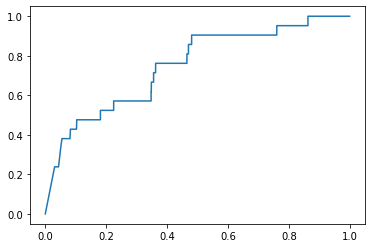

AUC Score Train:  0.7491475107313355

--------------------------------------------------


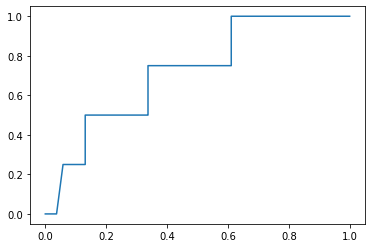

AUC Score Test:  0.718189461883408


In [151]:
clf, pred_labels_train, pred_labels_test, y_pred_prob_train, y_pred_prob_test = training_model_evaluation(X_train, X_test, y_train, y_test, BernoulliNB())

<Figure size 720x720 with 0 Axes>

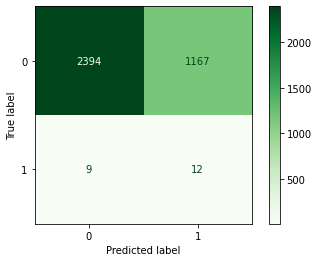

In [152]:
fig = plt.figure(figsize=(10, 10))
fig = plot_confusion_matrix(clf, X_train, y_train, cmap=plt.cm.Greens, values_format='')
plt.show()

<Figure size 720x720 with 0 Axes>

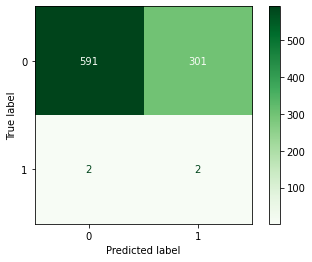

In [153]:
fig = plt.figure(figsize=(10, 10))
fig = plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Greens, values_format='')
plt.show()

In [163]:
df_class = pd.DataFrame(zip(pred_labels_train, 
                            np.round_(y_pred_prob_train, decimals=8),
                            pred_labels_test,
                            np.around(y_pred_prob_test, decimals=8)
                            ), 
                        columns=['label_train', 'prob_train',
                                 'label_test', 'prob_test'])

In [164]:
df_class.head()

,label_train,prob_train,label_test,prob_test
0,0,0.000000,1,1.0
1,0,0.000000,0,0.0
2,1,1.000000,0,0.0
3,1,0.999999,0,0.0
4,0,0.000000,1,1.0




---



---



X_train shape:  (4009, 1005)
X_test shape:  (1003, 1005)
y_train shape:  (4009,)
y_test shape:  (1003,)
Classes:  [0 1]
----------------------------------------
Accuracy Score Train:  0.9094537291095036
Accuracy Score Test:  0.8963110667996012
----------------------------------------

----------------------------------------
Train Report
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      3985
           1       0.04      0.58      0.07        24

    accuracy                           0.91      4009
   macro avg       0.52      0.75      0.51      4009
weighted avg       0.99      0.91      0.95      4009

Test Report
              precision    recall  f1-score   support

           0       0.99      0.90      0.95       995
           1       0.01      0.12      0.02         8

    accuracy                           0.90      1003
   macro avg       0.50      0.51      0.48      1003
weighted avg       0.98      0.90      0.94      

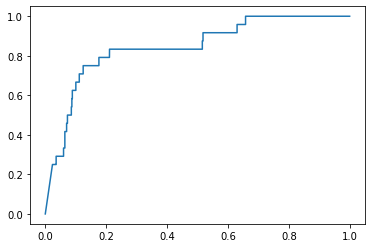

AUC Score Train:  0.8439512756168966

--------------------------------------------------


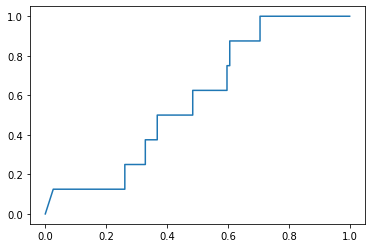

AUC Score Test:  0.5795226130653266


In [166]:
X_train, X_test, y_train, y_test = split_data(data_2, 'Response')
clf, pred_labels_train, pred_labels_test, y_pred_prob_train, y_pred_prob_test = training_model_evaluation(X_train, X_test, y_train, y_test, BernoulliNB())

<Figure size 720x720 with 0 Axes>

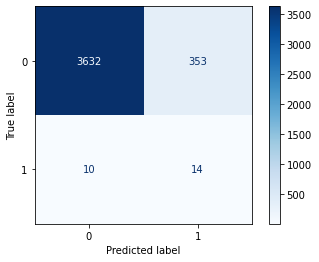

In [167]:
fig = plt.figure(figsize=(10, 10))
fig = plot_confusion_matrix(clf, X_train, y_train, cmap=plt.cm.Blues, values_format='')
plt.show()

In [168]:
df_class = pd.DataFrame(zip(pred_labels_train, 
                            np.round_(y_pred_prob_train, decimals=8),
                            pred_labels_test,
                            np.around(y_pred_prob_test, decimals=8)
                            ), 
                        columns=['label_train', 'prob_train',
                                 'label_test', 'prob_test'])

In [169]:
df_class.head(10)

,label_train,prob_train,label_test,prob_test
0,0,0.000000e+00,0,0.000000
1,0,0.000000e+00,0,0.000000
2,0,0.000000e+00,1,1.000000
3,0,0.000000e+00,0,0.000001
4,0,4.259000e-05,0,0.000000
5,1,1.000000e+00,0,0.000000
6,0,1.700000e-07,0,0.000000
7,0,0.000000e+00,0,0.000000
8,0,0.000000e+00,0,0.000000
9,0,2.917900e-03,0,0.000000


##### Alpha de Laplace

In [177]:
alpha_lt_1 = list(np.random.random_sample(size=5))
alpha_gt_1 = list(np.random.random_integers(1, high=50, size=5))
alpha = alpha_lt_1 + alpha_gt_1
print(alpha)

[0.3648118357474449, 0.5715337011304482, 0.07486331207012886, 0.6874558987589829, 0.5619551764422933, 42, 42, 25, 41, 37]


In [178]:
X = data_1.drop(columns='Response')
y = data_1['Response']

params = {'alpha': alpha}

bernoulli_grid = GridSearchCV(BernoulliNB(), param_grid=params, n_jobs=-1, cv=5, verbose=4)
bernoulli_grid.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    3.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None,
                                   fit_prior=True),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': [0.3648118357474449, 0.5715337011304482,
                                   0.07486331207012886, 0.6874558987589829,
                                   0.5619551764422933, 42, 42, 25, 41, 37]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=4)

In [180]:
X_train, X_test, y_train, y_test = split_data(data_1, 'Response')

X_train shape:  (3582, 171)
X_test shape:  (896, 171)
y_train shape:  (3582,)
y_test shape:  (896,)


In [181]:
print('Train Accuracy : %.3f' %bernoulli_grid.best_estimator_.score(X_train, y_train))
print('Test Accuracy : %.3f' %bernoulli_grid.best_estimator_.score(X_test, y_test))
print('Best Accuracy Through Grid Search : %.3f' %bernoulli_grid.best_score_)
print('Best Parameters : ', bernoulli_grid.best_params_)

Train Accuracy : 0.672
Test Accuracy : 0.662
Best Accuracy Through Grid Search : 0.673
Best Parameters :  {'alpha': 42}
